In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
sample = 2

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 2))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 2))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 5))

# Load CIFAR10 dataset

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:sample, :, :, :]
X_train = (X_train - 127.5) / 127.5

#X_train_out = X_train.reshape((X_train.shape[0], -1))

X_test = (X_test - 127.5) / 127.5
#X_test_out = X_test.reshape((X_test.shape[0], -1))

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#print(X_train.shape, X_train_out.shape, y_train.shape)
#print(X_test.shape, X_test_out.shape, y_test.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


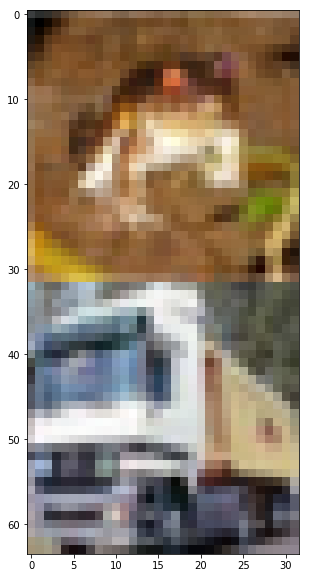

In [4]:
n = min(sample, 10)
figure = np.zeros((img_rows * n, img_cols, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = (orig_img * 127.5 + 127.5) / 255.
    
plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Model

In [5]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        #x = Conv2D(filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x

def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(filters, kernel_size, name='final' + name + channel_name[channel], padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * final_filters])(input_tensor)
        decoder_out_m = Conv2D(name='x_m' + str(channel), 
                               filters=mixture_components, 
                               kernel_size=1, 
                               strides=1,
                               activation='sigmoid')(x)
        decoder_out_invs_ = Conv2D(name='x_s' + str(channel),
                                   filters=mixture_components,
                                   kernel_size=1,
                                   strides=1,
                                   activation='sigmoid')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 2.0)(decoder_out_invs_)
        mixture_weights = Conv2D(name='weights' + str(channel),
                                 filters=mixture_components,
                                 kernel_size=1,
                                 strides=1,
                                 activation='softmax')(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [6]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
#x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))
model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
_________________________________________

In [7]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)

history = model.fit(
    #X_train, X_train_out,
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=30,
    callbacks=[TQDMNotebookCallback()],#, early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  7.679062128067017


,loss
count,9.000000
mean,151333.907986
std,119858.467123
min,37298.570312
0%,37298.570312
25%,50420.945312
50%,108442.257812
75%,232975.671875
95%,334473.287500
99%,351002.807500


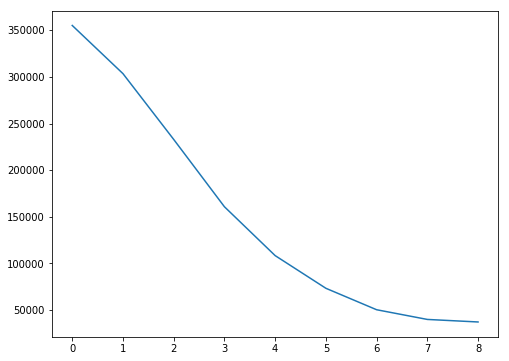

In [8]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [9]:
print(df)
assert False

             loss
0   355135.187500
1   303480.437500
2   232975.671875
3   160819.125000
4   108442.257812
5    73411.578125
6    50420.945312
7    40021.398438
8    37298.570312
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN


AssertionError: 

In [ ]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

In [ ]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def compute_pvals(m, invs):
    # TODO FIX ME when adding more mixtures
    pvals = []
    for i in range(256):
        if i == 0:
            pval = logistic.cdf(0.5 / 255., loc=m, scale=1. / np.exp(invs))
        elif i == 255:
            pval = 1. - logistic.cdf(254.5 / 255., loc=m, scale=1. / np.exp(invs))
        else:
            pval = (logistic.cdf(i / 255. + 0.5 / 255., loc=m, scale=1. / np.exp(invs))
                    - logistic.cdf(i / 255. - 0.5 / 255., loc=m, scale=1. / np.exp(invs)))
        pvals.append(pval)
    
    return pvals

def compute_mixture(ms, invs, weights):
    components = []
    for i in range(mixture_components):
        components.append(weights[i] * np.array(compute_pvals(ms[i], invs[i])))
    return np.sum(components, axis=0)

In [ ]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components
                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = x_out[n, i, j, offset:offset + mixture_components]
                    pvals = compute_mixture(x_ms, x_invs, weights)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if 0 <= i <= 16 and 0 <= j <= 16 and debug:
                        print("====", i, j, k)
                        print(" m: ", x_ms)
                        print(" invs: ", x_invs)
                        print(" weights: ", weights)
                        print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
                        #assert False
        if debug:
            print("row", i)
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [ ]:
m = 0.354
invs = np.exp(2.52)
for i in range(0, 256):
    if i > 0 and i < 255:
        x = logistic.cdf(i / 255. + (1 / 255. / 2), loc=m, scale=1./invs)
        y = logistic.cdf(i / 255. - (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x-y)
    elif i == 0:
        x = logistic.cdf(i / 255. + (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x)
    elif i == 255:
        x = 1. - logistic.cdf(i / 255. - (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x)

In [ ]:
X_train[0, 0, 0, :] * 255

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow((255 * img).astype(int))
plt.show()

In [ ]:
img[12:16, 12:16, :]

In [ ]:
df = pd.DataFrame(samples.reshape(400,3))
df.describe()

In [ ]:
#if os.environ.get('OUTDIR', None):
#    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
#    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))
#
#    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
#    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
#        json.dump(vals, f)

In [ ]:
#data = np.ones([3, 3, 6, 1])
#
#data.shape
#ptype = 'ba'
#mid = data.shape[0] // 2
#if ptype[0] == 'r':
#    filt_prev = 0
#    filt_thres = int(data.shape[2] / 3)
#elif ptype[0] == 'g':
#    filt_prev = int(data.shape[2] / 3)
#    filt_thres = int(2 * data.shape[2] / 3)
#else:
#    filt_prev = int(2 * data.shape[2] / 3)
#    filt_thres = data.shape[2]
#    
#print(data.shape, ptype, mid, filt_prev, filt_thres)
#
#for k1 in range(data.shape[0]):
#    for k2 in range(data.shape[1]):
#        for chan in range(data.shape[2]):
#            for filt in range(data.shape[3]):
#                if ptype[1] == 'a' and chan >= filt_prev:
#                    if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#                else:
#                    if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#    
#print(data[:, :, 0, 0])
#print(data[:, :, filt_thres-1, 0])
#data



#def data_generator(X_data, X_data_out, batch_size):
#    while True:
#        index = np.arange(len(X_data))
#        np.random.shuffle(index)
#        for i in range(len(X_data) // batch_size):
#            batch_in_data = X_data[index[i * batch_size: (i+1)*batch_size], :, :, :]
#            batch_out_data = X_data_out[index[i * batch_size: (i+1)*batch_size], :, :]
#            yield batch_in_data, to_categorical(batch_out_data, num_classes=256).reshape(batch_size, -1)
#            
#for x, y in data_generator(X_test, X_test_out, 1):
#    print(x.shape, y.shape)
#    break

# Notes

* Did the last conv layer wrong (did a masking layer, when I should have done a 1x1 on each channel) -- actually might want to actually do a type B mask on last layer...
* Debug using single image, then grow it
* GPU small, so cut down problem to 20x20x3; discretize outputs to 16 levels for each channel (vs. 256)
* Found the tensorflow loss function the best, didn't have to duplicate softmax, then call keras, which then converts back to a probability
* Don't need an explicit dense layer on output because loss function takes care of it for me.  Just use output of 1x1 conv directly.


# 2019-04-02

* Put together a small network, testing on 2 images
* Loss decreases but goes to NaN very quickly:

                     loss
        0   355135.187500
        1   303480.437500
        2   232975.671875
        3   160819.125000
        4   108442.257812
        5    73411.578125
        6    50420.945312
        7    40021.398438
        8    37298.570312
        9             NaN
        10            NaN
        
* I suspect it's something to do with the loss function.  I tried using the extra dummy "where" clause that the PixelCNN++ implementation has, but it didn't really solve my problem
* Ideas:
    * Maybe it's due to the `logsumexp`?  Weird b/c I'm using the tf version, which should be more stable
    * Also check the inv_stddev -- maybe I should be doing something different here?
    * The PixelCNN++ implementation also has a numerically stable `log_prob_from_logits` function (which is used on the mixture weights), maybe I need that?  Oh that implementation directly calculates log(softmax(.)), whereas I just go to softmax.  I guess log(small number) could overflow pretty easily?